In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np


In [7]:
transform_gray = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [8]:
datasets_dict = {
    "MNIST": datasets.MNIST(root="./data", train=True, download=True, transform=transform_gray),
    "FashionMNIST": datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_gray),
    "CIFAR10": datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_rgb)
}

testsets_dict = {
    "MNIST": datasets.MNIST(root="./data", train=False, transform=transform_gray),
    "FashionMNIST": datasets.FashionMNIST(root="./data", train=False, transform=transform_gray),
    "CIFAR10": datasets.CIFAR10(root="./data", train=False, transform=transform_rgb)
}

batch_size = 64

dataloaders = {
    name: DataLoader(ds, batch_size=batch_size, shuffle=True)
    for name, ds in datasets_dict.items()
}
testloaders = {
    name: DataLoader(ds, batch_size=batch_size, shuffle=False)
    for name, ds in testsets_dict.items()
}


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 608kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.70MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 230kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.4MB/s]
100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


In [9]:
def train_model(model, trainloader, testloader, device, epochs=30): #use few epochs for cloud running it takes so much time
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    train_acc, test_acc = [], []
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0) # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(trainloader.dataset) # Calculate average training loss
        train_loss.append(epoch_train_loss)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_test_loss = running_loss / len(testloader.dataset)
        test_loss.append(epoch_test_loss)
        test_accuracy = 100 * correct / total
        test_acc.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}") # Added loss to print statement

    return train_acc, test_acc, train_loss, test_loss

In [10]:
from torchvision.models import resnet18

# ResNet-18 model wrapper for variable input channels
class ResNet18Custom(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ResNet18Custom, self).__init__()
        self.model = resnet18(weights=None)
        if in_channels != 3:
            self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_results = {}
dataset_order = ["MNIST", "FashionMNIST", "CIFAR10"]
for name in dataset_order:
    print(f"\nTraining on {name} dataset (Direct Training - ResNet-18)...")
    in_channels = 3 if name == "CIFAR10" else 1
    model = ResNet18Custom(in_channels=in_channels, num_classes=10).to(device)

    trainloader = dataloaders[name]
    testloader = testloaders[name]

    start_time = time.time()
    train_acc, test_acc, train_loss, test_loss = train_model(model, trainloader, testloader, device)
    end_time = time.time()

    resnet_results[name] = (train_acc, test_acc, train_loss, test_loss, end_time-start_time)
    print(f"Training time: {end_time-start_time:.2f} seconds")



Training on MNIST dataset (Direct Training - ResNet-18)...
Epoch [1/2] | Train Acc: 96.36% | Test Acc: 98.66% | Train Loss: 0.1243 | Test Loss: 0.0449
Epoch [2/2] | Train Acc: 98.22% | Test Acc: 98.44% | Train Loss: 0.0605 | Test Loss: 0.0507
Training time: 1978.41 seconds

Training on FashionMNIST dataset (Direct Training - ResNet-18)...
Epoch [1/2] | Train Acc: 84.85% | Test Acc: 87.50% | Train Loss: 0.4208 | Test Loss: 0.3330
Epoch [2/2] | Train Acc: 88.92% | Test Acc: 88.95% | Train Loss: 0.3024 | Test Loss: 0.2917
Training time: 1943.06 seconds

Training on CIFAR10 dataset (Direct Training - ResNet-18)...
Epoch [1/2] | Train Acc: 50.45% | Test Acc: 59.17% | Train Loss: 1.3801 | Test Loss: 1.1667
Epoch [2/2] | Train Acc: 65.22% | Test Acc: 62.72% | Train Loss: 0.9868 | Test Loss: 1.1176
Training time: 1636.43 seconds


In [11]:
print(resnet_results)

NameError: name 'resnet_results' is not defined

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_order = ["MNIST", "FashionMNIST", "CIFAR10"]
resnet_seq_results = {}
previous_model = None
for name in dataset_order:
    print(f"\nTraining on {name} dataset (Curriculum Training - ResNet-18)...")
    in_channels = 3 if name == "CIFAR10" else 1
    model = ResNet18Custom(in_channels=in_channels, num_classes=10).to(device)

    if previous_model is not None:
        state_dict = previous_model.state_dict()
        new_state_dict = model.state_dict()
        for key in state_dict:
            if key in new_state_dict and state_dict[key].shape == new_state_dict[key].shape:
                new_state_dict[key] = state_dict[key]
        model.load_state_dict(new_state_dict)

    trainloader = dataloaders[name]
    testloader = testloaders[name]

    start_time = time.time()
    train_acc, test_acc, train_loss, test_loss = train_model(model, trainloader, testloader, device)
    end_time = time.time()

    resnet_seq_results[name] = (train_acc, test_acc, train_loss, test_loss, end_time-start_time)
    print(f"Training time: {end_time-start_time:.2f} seconds")

    previous_model = model



Training on MNIST dataset (Curriculum Training - ResNet-18)...
Epoch [1/2] | Train Acc: 96.05% | Test Acc: 98.16% | Train Loss: 0.1307 | Test Loss: 0.0614
Epoch [2/2] | Train Acc: 98.31% | Test Acc: 98.74% | Train Loss: 0.0586 | Test Loss: 0.0404
Training time: 1561.30 seconds

Training on FashionMNIST dataset (Curriculum Training - ResNet-18)...
Epoch [1/2] | Train Acc: 85.39% | Test Acc: 87.94% | Train Loss: 0.4159 | Test Loss: 0.3394
Epoch [2/2] | Train Acc: 89.43% | Test Acc: 89.44% | Train Loss: 0.2874 | Test Loss: 0.2993
Training time: 1550.75 seconds

Training on CIFAR10 dataset (Curriculum Training - ResNet-18)...
Epoch [1/2] | Train Acc: 49.97% | Test Acc: 60.13% | Train Loss: 1.4246 | Test Loss: 1.1371
Epoch [2/2] | Train Acc: 65.15% | Test Acc: 66.78% | Train Loss: 0.9886 | Test Loss: 0.9422
Training time: 1296.86 seconds


In [14]:
print(resnet_seq_results)

{'MNIST': ([96.045, 98.31], [98.16, 98.74], [0.13073564677660665, 0.058595889838784936], [0.06141704623363912, 0.04037740483474918], 1561.2995791435242), 'FashionMNIST': ([85.395, 89.42666666666666], [87.94, 89.44], [0.41586848857402803, 0.28744194106260934], [0.33941950795650483, 0.2993449460983276], 1550.7532675266266), 'CIFAR10': ([49.97, 65.154], [60.13, 66.78], [1.4245792433929443, 0.9885614743041993], [1.137091332435608, 0.942216351890564], 1296.863216161728)}


In [15]:
plt.figure(figsize=(14, 6))
for name, (train_acc, test_acc, _, _, _) in resnet_results.items():
    plt.plot(test_acc, label=f'{name} Test Accuracy')
    plt.plot(train_acc, label=f'{name} Train Accuracy', linestyle='--')
plt.title("Accuracy vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 6))
for name, (_, _, train_loss, test_loss, _) in resnet_results.items():
    plt.plot(test_loss, label=f'{name} Test Loss')
    plt.plot(train_loss, label=f'{name} Train Loss', linestyle='--')
plt.title("Loss vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'resnet_results' is not defined

<Figure size 1400x600 with 0 Axes>

In [ ]:
for name, (train_acc, test_acc, train_loss, test_loss, training_time) in resnet_results.items():
    print(f"--- Results for {name} ---")
    print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Final Testing Accuracy: {test_acc[-1]:.2f}%")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Testing Loss: {test_loss[-1]:.4f}")
    print(f"Total Training Time: {training_time:.2f} seconds")
    print("-" * (len(f"--- Results for {name} ---")))

--- Results for MNIST ---
Final Training Accuracy: 98.29%
Final Testing Accuracy: 98.89%
Final Training Loss: 0.0582
Final Testing Loss: 0.0352
Total Training Time: 1701.22 seconds
-------------------------
--- Results for FashionMNIST ---
Final Training Accuracy: 88.95%
Final Testing Accuracy: 89.16%
Final Training Loss: 0.3006
Final Testing Loss: 0.2932
Total Training Time: 1446.37 seconds
--------------------------------
--- Results for CIFAR10 ---
Final Training Accuracy: 65.54%
Final Testing Accuracy: 69.92%
Final Training Loss: 0.9846
Final Testing Loss: 0.8862
Total Training Time: 1231.39 seconds
---------------------------


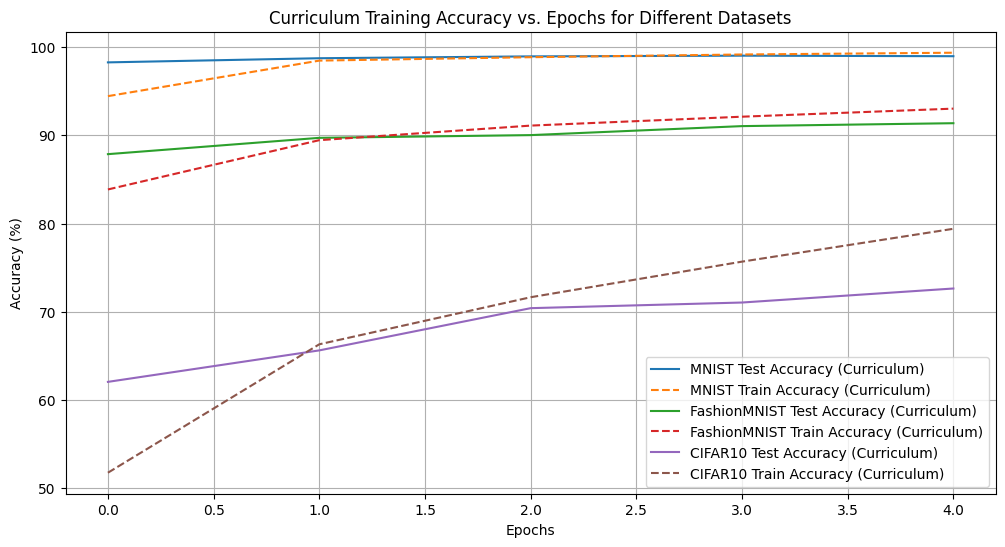

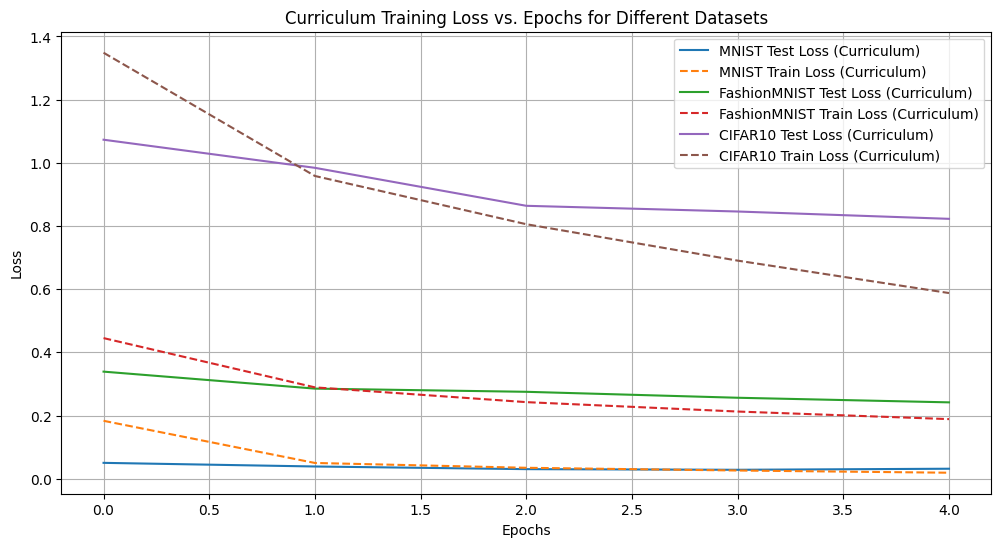

In [ ]:
plt.figure(figsize=(12, 6))
for name, (train_acc, test_acc, train_loss, test_loss) in resnet_seq_results.items():
    plt.plot(test_acc, label=f'{name} Test Accuracy (Curriculum)')
    plt.plot(train_acc, label=f'{name} Train Accuracy (Curriculum)', linestyle='--')
plt.title("Curriculum Training Accuracy vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for name, (train_acc, test_acc, train_loss, test_loss) in resnet_seq_results.items():
    plt.plot(test_loss, label=f'{name} Test Loss (Curriculum)')
    plt.plot(train_loss, label=f'{name} Train Loss (Curriculum)', linestyle='--')
plt.title("Curriculum Training Loss vs. Epochs for Different Datasets")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n\n==================== SUMMARY ====================")
for name in dataset_order:
    print(f"\n📘 {name} RESULTS:")
    if name in resnet_results:
        print(f"Direct Training     → Test Acc: {results[name][1]:.2f}% | Time: {resnet_results[name][4]:.2f}s")
    if name in resnet_seq_results:
        print(f"Curriculum Training → Test Acc: {resnet_seq_results[name][1]:.2f}% | Time: {resnet_seq_results[name][4]:.2f}s")
print("=================================================\n")



==================== SUMMARY ====================

📘 MNIST RESULTS:


TypeError: unsupported format string passed to list.__format__

In [ ]:
print("--- Comparison of Training Approaches on CIFAR10 ---")

# Get results for Direct Training on CIFAR10
if "CIFAR10" in resnet_results:
    direct_train_acc, direct_test_acc, direct_train_loss, direct_test_loss, direct_training_time = resnet_results["CIFAR10"]
    print("\nDirect Training on CIFAR10:")
    print(f"  Final Testing Accuracy: {direct_test_acc[-1]:.2f}%")
    print(f"  Final Testing Loss: {direct_test_loss[-1]:.4f}")
    print(f"  Total Training Time: {direct_training_time:.2f} seconds")
else:
    print("\nDirect training results for CIFAR10 not found.")

# Get results for Curriculum Training on CIFAR10
if "CIFAR10" in resnet_seq_results:
    seq_train_acc, seq_test_acc, seq_train_loss, seq_test_loss, seq_training_time = resnet_seq_results["CIFAR10"]
    print("\nCurriculum Training (MNIST -> FashionMNIST -> CIFAR10):")
    print(f"  Final Testing Accuracy: {seq_test_acc[-1]:.2f}%")
    print(f"  Final Testing Loss: {seq_test_loss[-1]:.4f}")
    print(f"  Total Training Time: {seq_training_time:.2f} seconds")
else:
    print("\nCurriculum training results for CIFAR10 not found.")

print("--------------------------------------------------")

--- Comparison of Training Approaches on CIFAR10 ---

Direct Training on CIFAR10:
  Final Testing Accuracy: 71.18%
  Final Testing Loss: 0.8334
  Total Training Time: 471.69 seconds


ValueError: not enough values to unpack (expected 5, got 4)